In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.linalg import cho_factor, cho_solve
import os, glob
from astropy import units as u


import dill as pickle

import scipy.linalg as sl
import scipy.integrate as sint
import scipy.interpolate as sinter

import la_forge
import scipy.stats as sstats


from tqdm import tqdm
import json
import pandas as pd
import pyarrow.feather as feather

plt.style.use('dark_background')
mpl.rcParams['figure.figsize'] = [20.0, 7.0]


# Import Data

In [2]:
# Functions to read/write a feather file and return a python dictionary (portable)
def convert_value(value):
    """
    Convert NumPy arrays to native objects in a way that preserves shape.
    Scalars are converted to native Python types.
    Arrays with ndim > 1 are stored as a dictionary with 'data' and 'shape'.
    """
    if isinstance(value, np.ndarray):
        if value.ndim > 1:
            return {"data": value.flatten().tolist(), "shape": value.shape}
        else:
            return value.tolist()
    elif isinstance(value, np.generic):
        # Convert NumPy scalar to Python scalar.
        return value.item()
    else:
        return value

def write_fourier_dataframe(pta_model, filename):
    # Create a list of dictionaries – each row corresponds to one pulsar.
    rows = []
    for pulsar, params in pta_model.items():
        row = {"pulsar": pulsar}
        for key, value in params.items():
            row[key] = convert_value(value)
        rows.append(row)

    # Create a DataFrame from the rows.
    df = pd.DataFrame(rows)

    # Write the DataFrame to a Feather file.
    feather.write_feather(df, filename)

def restore_value(x):
    """
    Restore a value that was saved by convert_value().
    If x is a dict with keys 'data' and 'shape', rebuild a NumPy array with that shape.
    If x is a list, convert it to a NumPy array.
    Otherwise, return x unchanged.
    """
    if isinstance(x, dict) and "data" in x and "shape" in x:
        arr = np.array(x["data"])
        try:
            return arr.reshape(x["shape"])
        except Exception as e:
            # In case the reshape fails, return the flat array.
            return arr
    elif isinstance(x, list):
        return np.array(x)
    else:
        return x

def read_fourier_dataframe(filename):
    #df_loaded = feather.read_feather(f'{project_dir}/data/{dataset}-fourier-model.feather')
    df_loaded = feather.read_feather(filename)

    # First convert the DataFrame to a list of row dictionaries.
    records = df_loaded.to_dict(orient="records")

    # Reconstruct the original nested dictionary.
    pta_model = {}
    for row in records:
        pulsar = row["pulsar"]
        params = {}
        for key, value in row.items():
            if key != "pulsar":
                params[key] = restore_value(value)
        pta_model[pulsar] = params

    return pta_model

In [3]:

project_dir = './'
pta_model = read_fourier_dataframe(f'{project_dir}/pta_model_gpta_2.feather')

## par_dict 
Purely written by gpt, just for reading your paramter file, you can ignore this

In [4]:
from pathlib import Path
import re
import json
import numpy as np
from typing import List, Dict

def load_param_names(path: str) -> List[str]:
   
    text = Path(path).read_text(encoding="utf-8")
    names = []
    for line in text.splitlines():
        line = line.strip()
        if not line or line.startswith("#"):
            continue
        parts = [p for p in re.split(r"[,\s]+", line) if p]
        names.extend(parts)
    if not names:
        raise ValueError("param_list.txt has no parameter names。")
    return names

def load_chain_matrix(path: str) -> np.ndarray:
   
    try:
        arr = np.loadtxt(path, dtype=float, comments="#", ndmin=2)
    except Exception:
        
        arr = np.genfromtxt(path, dtype=float, comments="#")
        arr = np.atleast_2d(arr)
    if arr.ndim != 2:
        raise ValueError("chain_1.txt has no two dimension matrix。")
    if arr.size == 0:
        raise ValueError("chain_1.txt is empty。")
    return arr

def build_sample_dicts(
    param_names: List[str],
    chain: np.ndarray,
    align: str = "left",
) -> List[Dict[str, float]]:
   
    n = len(param_names)
    m, k = chain.shape

    if k < n:
        raise ValueError(
            f"number of chain({k})is less than number of paramters ({n}),can't match , please check the file。"
        )
    if k > n:
        if align == "left":
            chain = chain[:, :n]
        elif align == "right":
            chain = chain[:, -n:]
        else:
            raise ValueError("align could either be 'left' or 'right'。")

    samples = [dict(zip(param_names, map(float, row))) for row in chain]
    return samples

if __name__ == "__main__":
    param_names = load_param_names("param_list.txt")
    chain = load_chain_matrix("chain_1.txt")
    big_array = build_sample_dicts(param_names, chain, align="left")
    with open("samples.json", "w", encoding="utf-8") as f:
        json.dump(big_array, f, ensure_ascii=False, indent=2)
    print(f" {len(big_array)} sampling, first few examples：")
    print(big_array[0])

 100001 sampling, first few examples：
{'J0030+0451_red_noise_gamma': 3.6039781182100143, 'J0030+0451_red_noise_log10_A': -10.043665246571784, 'J0030+0451_red_noise_log10_kappa': -17.569474403875617, 'J0034-0534_red_noise_gamma': 6.667684660836571, 'J0034-0534_red_noise_log10_A': -11.253477665420522, 'J0034-0534_red_noise_log10_kappa': -15.41479703965657, 'J0101-6422_red_noise_gamma': 6.72916524275286, 'J0101-6422_red_noise_log10_A': -15.273608194134036, 'J0101-6422_red_noise_log10_kappa': -16.909094101408694, 'J0102+4839_red_noise_gamma': 5.891793597698309, 'J0102+4839_red_noise_log10_A': -18.942072318865126, 'J0102+4839_red_noise_log10_kappa': -12.190698211238686, 'J0312-0921_red_noise_gamma': 6.401246316856674, 'J0312-0921_red_noise_log10_A': -10.225835203753324, 'J0312-0921_red_noise_log10_kappa': -16.70056008400239, 'J0340+4130_red_noise_gamma': 4.3356480961313935, 'J0340+4130_red_noise_log10_A': -12.241783490273706, 'J0340+4130_red_noise_log10_kappa': -10.393915542411081, 'J0418+6

# $\phi(\rho)$

In [5]:
import numpy as np
from dataclasses import dataclass
from typing import List, Dict, Optional
import numpy as np
from dataclasses import dataclass
from typing import List, Dict, Optional
import scipy.constants as sc

###### physical time constants: seconds per Julian year/day; FYR = 1/yr (in Hz)
yr = sc.Julian_year
day = sc.day
FYR= 1.0 / yr

def _unitvec_from_model_entry(entry):
    """
    entry: pta_model[name] dict that contains at least 'phi' and 'theta' (in radians).
    Convention used here is the standard spherical one:
      x = sin(theta) * cos(phi), y = sin(theta) * sin(phi), z = cos(theta).
    """
    phi   = float(entry['phi'])
    theta = float(entry['theta'])

    th = theta
    ph = phi
    c, s = np.cos, np.sin
    return np.array([s(th)*c(ph), s(th)*s(ph), c(th)], dtype=float)

# ---------------------- Hellings–Downs ORF ----------------------
def hellings_downs_orf(unitvecs: List[np.ndarray]) -> np.ndarray:
    """
    Build Γ using the Hellings–Downs curve. Off-diagonals: Γ_ab = (3/2)x ln x - x/4 + 1/2,
    where x = (1 - cos ζ_ab)/2 and cos ζ_ab = u_a · u_b. Diagonal is 1 here.
    """
    P = len(unitvecs)
    G = np.eye(P, dtype=float)
    for a in range(P):
        for b in range(a+1, P):
            ua, ub = unitvecs[a], unitvecs[b]
            cosang = float(np.clip(np.dot(ua, ub), -1.0, 1.0))
            x = 0.5 * (1.0 - cosang)
            val = 0.5 if x <= 0 else 1.5*x*np.log(x) - 0.25*x + 0.5
            G[a, b] = G[b, a] = val
    return G

# ---------------------- PSD → discrete prior variances ----------------------
def _rho_flat_tail(log10_A, gamma, f_Hz, df_Hz, log10_kappa=None):
    """
    Numerically equivalent to enterprise.powerlaw_flat_tail but implemented
    with explicit SI units (no astropy objects):
      PSD(f) = (A^2 / (12π^2)) * FYR^(-3) * (fc/FYR)^(-γ) * [1 + (f/fc)^2]^(-γ/2)   [s^3]
      rho    = max(PSD, flat_psd) * df_Hz                                              [s^2]
    If log10_kappa is None, no flat floor is applied. 'f_Hz' and 'df_Hz' are
    length-2K arrays where each Fourier frequency is duplicated for cosine/sine.
    """
    A      = 10.0**log10_A
    GAM    = float(gamma)
    FYR_Hz = FYR                                       # 1/yr in Hz (s^-1)
    logfc  = -1.879181246047625
    fc_Hz  = (10.0**logfc) * FYR_Hz                    # turnover frequency in Hz

    # PSD(f) in seconds^3
    norm_s3 = (A*A) / (12.0*np.pi**2) * (FYR_Hz**(-3.0)) * ((10.0**logfc)**(-GAM))
    shape   = (1.0 + (f_Hz/fc_Hz)**2.0)**(-0.5*GAM)
    PSD_s3  = norm_s3 * shape

    # Optional flat floor at the PSD level: flat_psd ~ 10^(2 kappa) * yr^3 in s^3
    if log10_kappa is not None:
        flat_psd_s3 = (10.0**(2.0*log10_kappa)) * (FYR_Hz**(-3.0))
        PSD_s3 = np.maximum(PSD_s3, flat_psd_s3)

    # Discretization: rho = PSD * (Δf in Hz), giving s^2 for each Fourier coefficient
    rho_s2 = PSD_s3 * df_Hz
    return rho_s2.astype(float)


# ------------ PTA_Lite reproduces enterprise's φ structure at H0/H1 ------------
@dataclass
class PTA_Lite:
    """
    Matches enterprise's Fourier construction:
      - Per pulsar: 2K Fourier coefficients (cos/sin pairing for K positive freqs).
      - RN (intrinsic red noise): uses all K freqs → 2K coeffs.
      - GW (common red process): only first G freqs are active → 2G coeffs, then zero-pad to 2K.
      - H0 (mode='curn'): returns a list of per-pulsar diagonal vectors = ρ_RN + ρ_GW_padded.
      - H1 (mode='hd')  : returns the full matrix Φ_C = I⊗diag(ρ_RN) + Γ⊗diag(ρ_GW_padded).
    """
    pta_model: Dict[str, Dict]

    components: int = 10         # K (number of positive Fourier freqs per pulsar)
    gw_components: int = 5       # G (how many GW freqs are nonzero)
    rn_name: str = "red_noise"
    mode: str = "curn"           # 'curn' (no cross-pulsar corr) or 'hd' (HD-ORF)

    def __post_init__(self):
        ###### Fix pulsar order and compute a unified Tspan (seconds)
        names = list(self.pta_model.keys())               # e.g. ['J0613-0200', 'J1713+0747', ...]
        self.pulsars = names
        self.Tspan = float(max(d['Tspan'] for d in self.pta_model.values())) * sc.Julian_year

        ###### Ensure all pulsars share the same number of Fourier freqs K
        K = int(next(iter(self.pta_model.values()))['nfrequencies'])
        if not all(int(d['nfrequencies']) == K for d in self.pta_model.values()):
            raise ValueError("All pulsars must share the same nfrequencies (K).")
        self.components = K

        ###### Build the frequency grid and step sizes in Hz, then duplicate each for cos/sin → length 2K
        base    = np.arange(1, self.components+1, dtype=float) / self.Tspan   # ν_k = k / Tspan
        df_base = np.diff(np.concatenate(([0.0], base)))                       # Δν_k = ν_k - ν_{k-1}
        self.f_rep  = np.repeat(base,   2)   # [f1,f1, f2,f2, ..., fK,fK]
        self.df_rep = np.repeat(df_base, 2)  # [Δf1,Δf1, ..., ΔfK,ΔfK]

        ###### Select the first G freqs (2G coeffs) for the common GW process, zero beyond 2G
        g = int(self.gw_components)
        self.f_rep_gw  = self.f_rep[:2*g]
        self.df_rep_gw = self.df_rep[:2*g]

        ###### Build the ORF Γ for 'hd' mode from sky positions; otherwise we keep Γ as identity (unused)
        unitvecs = [ _unitvec_from_model_entry(self.pta_model[name]) for name in self.pulsars ]
        if self.mode == "hd" and all(v is not None for v in unitvecs):
            self.Gamma = hellings_downs_orf(unitvecs) if self.mode == "hd" else np.eye(len(self.pulsars))
        else:
            if self.mode == "hd":
                print("[PTA_Lite] Warning: missing/ambiguous sky positions; Γ=I.")
            self.Gamma = np.eye(len(self.pta_model.keys()), dtype=float)

    def get_phi(self, par_dict: Dict[str, float]):
        """
        Return φ_N (H0, list of per-psr diagonals) when mode='curn';
        Return φ_C (H1, full matrix) when mode='hd'.
        Naming convention for per-psr RN parameters in 'par_dict':
          <psrname>_<rn_name>_log10_A,  <psrname>_<rn_name>_gamma,  <psrname>_<rn_name>_log10_kappa
        Global GW parameters: 'gw_log10_A', 'gw_gamma'.
        """
        P = len(self.pulsars); K = self.components; G = self.gw_components

        ###### Common GW spectrum (shared A, γ), with NO flat floor (log10_kappa=None)
        try:
            gw_log10_A = float(par_dict["gw_log10_A"])
            gw_gamma   = float(par_dict["gw_gamma"])
        except KeyError as e:
            raise KeyError(f"missing {e} (need 'gw_log10_A' & 'gw_gamma')")
        gw_kappa_fixed = None
        rho_gw_head = _rho_flat_tail(gw_log10_A, gw_gamma, self.f_rep_gw, self.df_rep_gw, gw_kappa_fixed)  # (2G,)
        pad_len = 2*K - 2*G
        rho_gw_padded = np.concatenate([rho_gw_head, np.zeros(pad_len, dtype=float)])  # (2K,)

        ###### Per-pulsar RN: each has its own (A, γ, κ); build both the H0 diagonal and H1 RN blocks
        per_psr_diag = []    # for H0: per-psr vector of length 2K = ρ_RN + ρ_GW_padded
        rn_blocks = []       # for H1: list of diag(ρ_RN) to blkdiag later
        for name in self.pulsars:
            kA = f"{name}_{self.rn_name}_log10_A"
            kg = f"{name}_{self.rn_name}_gamma"
            kk = f"{name}_{self.rn_name}_log10_kappa"
            if kA not in par_dict or kg not in par_dict or kk not in par_dict:
                raise KeyError(f"missing RN keys for {name}: '{kA}', '{kg}' (optional '{name}_{self.rn_name}_log10_kappa')")

            rn_log10_A     = float(par_dict[kA])
            rn_gamma       = float(par_dict[kg])
            rn_log10_kappa = float(par_dict[kk])

            rho_rn = _rho_flat_tail(rn_log10_A, rn_gamma, self.f_rep, self.df_rep, rn_log10_kappa)  # (2K,)
            per_psr_diag.append(rho_rn + rho_gw_padded)
            rn_blocks.append(np.diag(rho_rn))

        ###### H0 (curn): return a list (length P) of per-psr diagonals (each length 2K)
        if self.mode == "curn":
            return per_psr_diag

        ###### H1 (hd): Φ_C = I⊗diag(ρ_RN) + Γ⊗diag(ρ_GW_padded)
        phi = _block_diag(*rn_blocks)                             # I ⊗ diag(ρ_RN)
        phi += np.kron(self.Gamma, np.diag(rho_gw_padded))        # Γ ⊗ diag(ρ_GW_padded)
        return phi

def _block_diag(*mats):
    """
    Manually assemble a block-diagonal matrix from a list of square matrices.
    Equivalent to scipy.linalg.block_diag but without the dependency.
    """
    if not mats: return np.zeros((0,0), float)
    r = sum(M.shape[0] for M in mats); c = sum(M.shape[1] for M in mats)
    out = np.zeros((r,c), float); i=j=0
    for M in mats:
        rr,cc = M.shape; out[i:i+rr, j:j+cc] = M; i+=rr; j+=cc
    return out

In [6]:
K = next(iter(pta_model.values()))['nfrequencies']
P = len(pta_model)
par_dict= big_array[-1]
pta_h0 = PTA_Lite(pta_model, mode='curn', components=K, gw_components=5, rn_name='red_noise')
pta_h1 = PTA_Lite(pta_model, mode='hd',   components=K, gw_components=5, rn_name='red_noise')

phiN_list = pta_h0.get_phi(par_dict)     # List length P, each (2K,)
phiC      = pta_h1.get_phi(par_dict)     # (2K*P, 2K*P)



# Fourier Detection Statistics

In [7]:
import numpy as np
import scipy.linalg as sl

class FourierDetectionStatistic:
    """
    Fourier-domain Detection Statistic calculation. providing detection statistics , y as data ,Q as filter matrix and sigma_y for 
    the covariance matrix of y (for p value calculation).

    Parameters
    ----------
    pta_h0, pta_h1 : PTA objects
        h0 supplies φ_N(ρ) (per pulsar, last K coefficients), pta_h0.get_phi(par_dict);
        h1 supplies φ_C(ρ) including cross-correlations (big matrix), given by pta_h1.get_phi(par_dict).
    pta_model : dict
        Your dict with per-pulsar items:
          pta_model[name]['phiinv'], ['Sigma'], ['Sigma_inv'], ['a_hat'].
    fourier_num : int
        K: number of Fourier coefficients kept per pulsar (take the last K). In radio pulsars, Rutger used 60 for radio pulsars; 20 for the gamma pulsars u gived me 
    proj_method : {"mask","svd"}
        How to build the low-rank projector G from Δφ:
        - "mask": take standard-basis columns on the nonzero support of Δφ. (I recommend you always use this one ,it's the one i described in pdf)
        - "svd" : thin SVD of Δφ, take U[:, keep].  (chatgpt give me this as an extra option, so why not?)
    tol : float
        Threshold for zero-detection in "mask" mode (|entry|<=tol → zero). Default 1e-30. (tollerance value for selection projector matrix, it could be even lower)
    rel_eps : float or None
        Relative SVD cutoff in "svd" mode. None ⇒ use (machine_eps * n * smax). (tollerance value for selection projector matrix)
    order : list[str] or None
        Pulsar order. If None, use pta_h0.pulsars. (an extra option given by chatgpt. I've been always using "None" anyway.)
    verbose : bool
        Print shapes and scalar diagnostics. (an extra option given by chatgpt, I always used verbose=False for clean output)

    Main API
    --------
    compute_os(params) -> float
        Return the deflection-type OS value.
    get_deflection_coordinates(params, normalize_Q=True)
        Return (OS_value, y, Q,Sigma_y), where os_value is detection statistics, y = G_A^T â, 
        Q = Φ_N ΔΦ Φ_N^T (optionally normalized by the denominator), sigma_y is covariance matrix of y for p value calculation
    """

    # ----------------------------------------------------------------------------------
    # High-level math map (for readers):
    #
    #  - Σ^{-1} = Σ0^{-1} + φ_N^{-1} - Φ0^{-1};  â = Σ Σ0^{-1} â0         (transfer between parameters)
    #  - Δφ = φ_C - φ_N                                                    (contrast get_phi between H1 and H0)
    #  - Low-rank projection: build G ∈ R^{n×r} from Δφ, then reduce:
    #        y       = G_A^T â,                          G_A spans range(A), A = φ_N^{-1} G
    #        Φ_N     = G_A^T φ_N^{-1} G                  (r_A×r)
    #        ΔΦ      = G^T Δφ G                          (r×r)
    #        Q_num   = Φ_N ΔΦ Φ_N^T                      (r_A×r_A)
    #        Numerator = y^T Q_num y
    #  - Normalization (real basis): Nor = sqrt( 2 Tr( [ (Σ^{-1} - φ_N^{-1}) Δφ φ_N^{-1} Σ ]^2 ) )
    #    Then the normalized Q = Q_num / Nor, and OS = (y^T Q_num y) / Nor.
    #
    # Shapes:
    #   - n = total number of kept Fourier modes across pulsars (sum over pulsars of K)
    #   - r = rank of Δφ support (columns/rows retained by G)
    #   - r_A = rank of A = φ_N^{-1} G  (≤ r), basis given by thin SVD (U columns kept)
    # ----------------------------------------------------------------------------------

    def __init__(
        self, pta_h0, pta_h1, pta_model,
        fourier_num=60, proj_method="mask",
        tol=0, rel_eps=None, order=None, verbose=False
    ):
        # Store external objects and options
        self.pta_h0 = pta_h0
        self.pta_h1 = pta_h1
        self.pta_model = pta_model
        self.fourier_num = int(fourier_num)

        self.proj_method = str(proj_method)
        self.tol = float(tol)
        self.rel_eps = rel_eps
        self.verbose = bool(verbose)

        # Pulsar order used to stack block-diagonals and a_hat consistently
        self.order = list(order) if order is not None else list(pta_h0.pulsars)

        # (1) Build big block-diagonal matrices from the per-pulsar model:
        #     BigPhi0Inv = Φ0^{-1} (prior inverse at ρ0), Sigma0 = Σ0, Sigma0Inv = Σ0^{-1}
        #     These are used for the ρ-transfer formulas Σ^{-1} = Σ0^{-1} + φ_N^{-1} - Φ0^{-1}
        self.BigPhi0Inv, self._slc = self._build_block_diag_from_model('phiinv')
        self.Sigma0,    _          = self._build_block_diag_from_model('Sigma')
        self.Sigma0Inv, _          = self._build_block_diag_from_model('Sigma_inv')

        # (2) Stack â0 across pulsars (each K-vector) → (#psr, K) → ravel to (n,)
        #     We will later compute â(ρ) = Σ Σ0^{-1} â0.
        self.ahat0 = self._stack_a_hat()

        # (3) Indices bookkeeping for the "last-K" coefficients per pulsar
        self._per_psr_param_len = None
        self._idx_lastK = None

    def compute_os(self, params):
        """Return detection statistic.
        (if you need this only)
        """
        os_val, _, _ = self.get_deflection_coordinates(params)
        return os_val

    def get_deflection_coordinates(self, params):
        """
        Return (OS_value, y, Q).

        y      = G_A^T â
        Q_num  = Φ_N ΔΦ Φ_N^T  with  Φ_N = G_A^T φ_N^{-1} G,  ΔΦ = G^T Δφ G
        Denom  = sqrt( 2 Tr( [ (Σ^{-1} - φ_N^{-1}) Δφ φ_N^{-1} Σ ]^2 ) )
        Sigma_y = Cov(y|H0).
        """
        # ---------- 1) ρ-dependent pieces: φ_N, φ_N^{-1}, φ_C, Δφ ----------
        # From H0 (diagonal blocks per pulsar, last K per pulsar) and H1 (full cross-correlation),
        # compute φ_N (diag), φ_C (dense), and Δφ = φ_C - φ_N (difference).
        phiN, phiNinv, phiC, dphi = self._phiN_phiC_delta(params)

        # ---------- 2) Σ^{-1}, Σ, and â(ρ) ----------
        # Use Σ^{-1} = Σ0^{-1} + φ_N^{-1} - Φ0^{-1}, then recover Σ by Cholesky solve.
        # Compute â(ρ) = Σ Σ0^{-1} â0 (ρ-transfer identity).
        SigmaInv, Sigma = self._Sigma_and_inv(phiNinv)
        ahat = Sigma @ (self.Sigma0Inv @ self.ahat0)

        # ---------- 3) Dimension reduction: G from Δφ; G_A from A = φ_N^{-1} G ----------
        # Build G capturing the low-rank support of Δφ (either by mask or SVD).
        # Then build G_A as an orthonormal basis for range(A) with thin SVD on A = φ_N^{-1} G.
        G  = self._project_G(dphi)             # n×r
        GA = self._project_GA(phiNinv @ G)     # n×rA

        # Reduced coordinates and reduced operators:
        #   y        = G_A^T â
        #   Φ_N_red  = G_A^T φ_N^{-1} G
        #   ΔΦ_red   = G^T Δφ G
        y         = GA.T @ ahat                               # rA
        PhiN_red  = GA.T @ phiNinv @ G                        # rA×r
        dphi_red  = G.T  @ dphi     @ G                       # r×r

        # ---------- 4) Numerator: y^T Φ_N ΔΦ Φ_N^T y ----------
        # This is exactly the unnormalized quadratic form in the reduced subspace.
        Q_num = PhiN_red @ dphi_red @ PhiN_red.T              # rA×rA
        numerator = float(y.T @ (Q_num @ y))

        # ---------- 5) Denominator (full-dim) ----------
        # Nor = sqrt( 2 Tr( [ (Σ^{-1} - φ_N^{-1}) Δφ φ_N^{-1} Σ ]^2 ) ).
        # Compute the inner matrix M first, then Tr(MM) is the squared Frobenius norm.
        M = (SigmaInv - phiNinv) @ dphi @ (phiNinv @ Sigma)
        den = np.sqrt(2.0 * np.trace(M @ M))

        # Normalize Q if requested; OS = numerator / den
        Q = Q_num / den 
        os_val = numerator / den if den > 0 else np.nan

        # Sigma_y = Cov(y | H0) = G_A^T (φ_N - Σ) G_A   (see your PDF derivation)
        Sigma_y= GA.T @ (phiN- Sigma) @ GA

        if self.verbose:
            print(f"[FourierDS] y:{y.shape}, Q:{Q.shape}, num={numerator:.6e}, den={den:.6e}, OS={os_val:.6e}")

        return os_val, y, Q ,  Sigma_y

    # ====================== the exact steps from your notebook ======================
    def _build_block_diag_from_model(self, field):
        """
        Build a big block-diagonal from pta_model[name][field].
        - If a value is 1D (diagonal entries), convert to a diagonal matrix.
        - If 2D square, use as-is.
        Also returns per-pulsar slice ranges in the big matrix.

        Math intent: build Σ0, Σ0^{-1}, Φ0^{-1} in block-diagonal form across pulsars.
        Implementation notes:
          * Preserves per-pulsar block sizes and records index slices for later use.
          * Ensures dtype=float for LAPACK compatibility.
        """
        blocks, sizes = [], []
        for name in self.order:
            M = np.asarray(self.pta_model[name][field])
            if M.ndim == 1:
                M = np.diag(M)  # turn a diagonal vector into a square diag matrix
            elif M.ndim != 2 or M.shape[0] != M.shape[1]:
                raise ValueError(f"{name}: {field} must be vector or square matrix, got {M.shape}")
            blocks.append(M.astype(float))
            sizes.append(M.shape[0])

        Big = sl.block_diag(*blocks)  # big block-diagonal matrix
        slc, start = {}, 0
        for name, m in zip(self.order, sizes):
            slc[name] = slice(start, start + m)
            start += m
        return Big, slc

    def _stack_a_hat(self):
        """
        Stack each pulsar's a_hat (K,) into (#psr, K) and ravel to (n,).

        Math: â0 is concatenation of last-K Fourier coefficients per pulsar.
        Implementation: validate each 'a_hat' matches requested K.
        """
        rows = []
        for name in self.order:
            a = np.asarray(self.pta_model[name]['a_hat'], dtype=float)
            if a.shape != (self.fourier_num,):
                raise ValueError(f"{name}: a_hat must be ({self.fourier_num},), got {a.shape}")
            rows.append(a)
        return np.vstack(rows).ravel()

    def _ensure_lastK_indices(self, params):
        """
        Cache global indices for the last K coefficients per pulsar.

        Math: we operate only on the highest-frequency K modes per pulsar (as per your setup).
        Implementation:
          - per pulsar, get full Fourier length m; take the last K indices.
          - Build a global index vector for slicing dense φ_C big matrix.
        """
        if self._per_psr_param_len is None:
            per = [len(v) for v in self.pta_h0.get_phi(params)]
            self._per_psr_param_len = np.array(per, dtype=int)

            K = self.fourier_num
            idx, start = [], 0
            for m in self._per_psr_param_len:
                idx.extend(range(start + m - K, start + m))  # pick last K of each pulsar
                start += m
            self._idx_lastK = np.array(idx, dtype=int)

            
    def _phiN_phiC_delta(self, params):
        """
        φ_N: from H0, take the last K diagonal entries per pulsar → big diagonal.
        φ_C: from H1, take the last K×K block per pulsar pair from the big matrix.
        Δφ = φ_C - φ_N.

        Math:
          - φ_N is block-diagonal (per pulsar); here represented as a diagonal matrix in full n×n.
          - φ_C is dense across pulsars (Hellings–Downs etc.); we restrict to last-K indices.
          - Δφ is the contrast driving the statistic.

        Implementation: uses cached _idx_lastK to slice the big φ_C efficiently.
        """
        self._ensure_lastK_indices(params)
        K = self.fourier_num

        # H0: list of 1D arrays. Keep the last K per pulsar → big diagonal φ_N.
        diag = []
        for v in self.pta_h0.get_phi(params):
            diag.extend(v[-K:])
        diag = np.asarray(diag, dtype=float)
        phiN    = np.diag(diag)
        phiNinv = np.diag(1.0 / diag)

        # H1: big matrix with cross-correlations, pick the last-K indices
        big  = self.pta_h1.get_phi(params)
        I    = self._idx_lastK
        phiC = big[np.ix_(I, I)].astype(float)

        dphi = phiC - phiN
        return phiN, phiNinv, phiC, dphi

    def _Sigma_and_inv(self, phiNinv):
        """
        Σ^{-1} = Σ0^{-1} + φ_N^{-1} - Φ0^{-1}; obtain Σ by Cholesky.

        Math: This is the ρ-transfer identity to move from (Σ0, Φ0) at ρ0 to (Σ, φ_N) at current ρ.
        Implementation: build Σ^{-1} then invert via Cholesky for numerical stability (SPD).
        """
        SigmaInv = (self.Sigma0Inv + phiNinv - self.BigPhi0Inv).astype(float)
        cf = sl.cho_factor(SigmaInv, lower=True, check_finite=False)
        Sigma = sl.cho_solve(cf, np.eye(SigmaInv.shape[0]))
        return SigmaInv, Sigma

    # ----------------------- low-rank projectors: G and G_A -----------------------
    def _project_G(self, dphi):
        """
        Build G (n×r) from Δφ:
          - "mask": take standard basis on nonzero support (rows or cols > tol).
          - "svd" : thin SVD, take U[:, keep].

        Math:
          - If Δφ has zero-only rows/cols for some modes, those modes do not contribute;
            "mask" mode selects the active coordinate subspace.
          - "svd" mode picks the dominant left singular vectors of Δφ (range(Δφ)).

        Implementation:
          - Mask: boolean OR over rows/cols identifies active indices; build a selection matrix.
          - SVD : LAPACK thin-SVD; threshold s > thr keeps columns.
        """
        M = np.asarray(dphi, dtype=float)

        if self.proj_method == "mask":
            nonzero_row = np.any(np.abs(M) > self.tol, axis=1)
            nonzero_col = np.any(np.abs(M) > self.tol, axis=0)
            mask = nonzero_row | nonzero_col
            idx = np.flatnonzero(mask)
            r = idx.size
            G = np.zeros((M.shape[0], r), dtype=float)
            if r > 0:
                G[idx, np.arange(r)] = 1.0  # standard-basis selector
            return G

        elif self.proj_method == "svd":
            U, s, _ = self._safe_svd(M)
            thr = self._svd_threshold(s, M.shape[0])
            keep = np.flatnonzero(s > thr)
            if keep.size == 0:
                keep = np.array([0], dtype=int)  # degenerate case: keep one column to avoid empty basis
            return U[:, keep]

        else:
            raise ValueError("proj_method must be 'mask' or 'svd'")

    def _project_GA(self, A):
        """
        Build G_A as the column-space basis of A = φ_N^{-1} G via thin SVD.

        Math: G_A spans range(A) with orthonormal columns (G_A^T G_A = I).
              This is the QR/SVD step in your dimension reduction derivation.
        Implementation: thin SVD (full_matrices=False), keep singular vectors above threshold.
        """
        U, s, _ = self._safe_svd(np.asarray(A, dtype=float))
        thr = self._svd_threshold(s, A.shape[0])
        keep = np.flatnonzero(s > thr)
        if keep.size == 0:
            keep = np.array([0], dtype=int)
        return U[:, keep]

    @staticmethod
    def _safe_svd(M):
        """
        Robust thin SVD wrapper:
          - try default backend; if it fails, fall back to 'gesvd'.
        Returns U, s, VT with full_matrices=False.
        """
        try:
            return sl.svd(M, full_matrices=False, check_finite=False)
        except sl.LinAlgError:
            return sl.svd(M, full_matrices=False, lapack_driver='gesvd', check_finite=False)

    def _svd_threshold(self, s, n):
        """
        SVD cutoff:
          - rel_eps is None: thr = max(n,1) * eps * smax   (LAPACK-style)
          - else:             thr = rel_eps * smax

        Math/implementation: avoids keeping numerically null directions; scales with matrix size.
        """
        smax = float(s[0]) if s.size else 0.0
        if self.rel_eps is None:
            eps = np.finfo(float).eps
            return max(n, 1) * eps * smax
        else:
            return float(self.rel_eps) * smax

In [8]:
par_dict=big_array[-1]
os_fourier = FourierDetectionStatistic(
    pta_h0, pta_h1, pta_model,
    fourier_num=20,
    proj_method="mask",  # or "svd"
    tol=1e-30,
    rel_eps=None,
    order=None,
    verbose=False
)

os_val, y, Q,Sigma_y = os_fourier.get_deflection_coordinates(par_dict)

# p-value
### for the last element

In [9]:
import numpy as np
import scipy.linalg as sl
from scipy import integrate as sint

def imhof(u, x, eigs, output='cdf'):
    theta = 0.5 * np.sum(np.arctan(eigs[:, None] * u), axis=0) - 0.5 * x * u
    rho   = np.prod((1.0 + (eigs[:, None] * u)**2)**0.25, axis=0)
    return (np.sin(theta) / (u * rho)) if output=='cdf' else (np.cos(theta) / rho)

def gx2cdf(eigr, xs, cutoff=1e-36, limit=200, epsabs=1e-7):
    eigs = eigr[:cutoff] if cutoff > 1 else eigr[np.abs(eigr) > cutoff]
    return np.array([0.5 - sint.quad(lambda u: float(imhof(u, x, eigs)),
                                     0, np.inf, limit=limit, epsabs=epsabs)[0] / np.pi
                     for x in np.atleast_1d(xs)])

def spectral_and_pvalue_from_yQ( Q, Sigma_y, os_val, *,
                                complex_mode=False,
                                cutoff=1e-12,
                                tol_ratio=1e-12,
                                jitter_ratio=None):
    """
    Purpose
    -------
    Given a quadratic form D = y^T Q y under H0 with y ~ N(0, Sigma_y),
    compute the (right-tail) p-value P{ D >= os_val | H0 } via Imhof's method.

    Math mapping
    ------------
    1) Stabilize Sigma_y to be PSD:
       - Eigen-decompose Sigma_y = V diag(w) V^T
       - Clip tiny negative eigenvalues (relative to the mean positive one).
       - Rebuild PSD covariance Cy_psd = V diag(w_+) V^T.
    2) Whiten by Cholesky: Cy_psd = L L^T (or L^T L), set S = L^T Q L.
       If y ~ N(0, Cy_psd), then y = L ε with ε ~ N(0, I), hence
         D = y^T Q y = ε^T (L^T Q L) ε = ε^T S ε.
    3) Diagonalize S = U diag(λ) U^T, then
         D  = Σ_i λ_i z_i^2,   z = U ε ~ N(0, I).
       Therefore D follows a generalized chi-square with weights λ_i.
    4) Use Imhof to evaluate F_D(os_val), then p_right = 1 - F_D(os_val).
       If `complex_mode=True`, duplicate eigenvalues (models complex basis).

    Parameters
    ----------
    Q : (rA, rA)
        Symmetric matrix of the quadratic statistic in the reduced basis
        (it can be already normalized outside; here we just use it as-is).
    Sigma_y : (rA, rA)
        Covariance of y under H0 (e.g. Sigma_y = G_A^T (φ_N - Σ) G_A).
    os_val : float
        Observed value d_obs of the statistic D = y^T Q y.
    complex_mode : bool
        If True, duplicate each eigenvalue λ_i → models complex representation
        (real/imag parts) where each degree occurs twice.
    cutoff : float
        |λ|-cutoff used inside gx2cdf/Imhof to drop extremely small weights.
    tol_ratio : float
        Relative tolerance to clip tiny negative eigenvalues of Sigma_y.
        We compare min negative |w| to mean positive eigenvalue; if the ratio
        exceeds tol_ratio, we raise, else we clamp negatives to zero.
    jitter_ratio : float or None
        If Cholesky of the PSD-fixed covariance fails (semi-definiteness),
        add a diagonal jitter = jitter_ratio * mean_pos to make it Choleskyable.
        If None, uses tol_ratio.

    Returns
    -------
    p_right : float
        Right-tail p-value P{ D >= os_val | H0 }.
    """

    # --- 1) PSD repair of Sigma_y: clip tiny negative eigenvalues relative to mean positive ---
    # Eigendecompose Sigma_y
    w, V = sl.eigh(Sigma_y, check_finite=False)
    pos = (w > 0.0)
    mean_pos = float(np.mean(w[pos])) if np.any(pos) else float(np.mean(np.abs(w))) if w.size else 0.0
    if mean_pos <= 0.0:
        # Extreme degeneracy: no positive spectrum → cannot stabilize to a proper covariance
        raise np.linalg.LinAlgError("Sigma_y has no positive spectrum; cannot stabilize.")

    neg = (w < 0.0)
    if np.any(neg):
        worst = float(np.max(np.abs(w[neg]) / mean_pos))
        if worst > tol_ratio:
            # Significant negative mass → likely model mismatch or numerical error too large
            raise np.linalg.LinAlgError(
                f"Sigma_y not PSD: min_eig={w.min():.3e}, mean_pos={mean_pos:.3e}, "
                f"ratio={worst:.3e} > tol_ratio={tol_ratio:.3e}"
            )
        # Clamp tiny negative eigenvalues to zero (stay PSD)
        w[neg] = 0.0

    # Rebuild stabilized covariance: Cy_psd = V diag(w_+) V^T
    # Use column scaling trick: V @ diag(w) @ V.T == (V * w) @ V.T
    Cy_psd = (V * w[None, :]) @ V.T

    # --- 2) Cholesky factor; if semi-definite, add a tiny jitter on the diagonal and retry ---
    if jitter_ratio is None:
        jitter_ratio = tol_ratio
    jitter = jitter_ratio * mean_pos
    try:
        L = np.linalg.cholesky(Cy_psd)
    except np.linalg.LinAlgError:
        L = np.linalg.cholesky(Cy_psd + jitter * np.eye(Cy_psd.shape[0]))

    # --- 3) Spectrum of S = L^T Q L (this is the weight matrix for the gen. chi-square) ---
    S = L.T @ Q @ L
    lam, U = sl.eigh(S, check_finite=False)

    # --- 4) Build λ-list depending on real/complex modeling ---
    # For complex models (e.g. exp(i 2πft)), each real DOF appears twice → duplicate λ
    lam_eff = np.repeat(lam, 2) if complex_mode else lam

    # --- 5) Imhof CDF at the observed value → right-tail p-value ---
    F = gx2cdf(lam_eff, [float(os_val)], cutoff=cutoff)[0]
    p_right = 1.0 - F
    return p_right

In [10]:
os_val, y, Q, Sigma_y = os_fourier.get_deflection_coordinates(par_dict)

p_right = spectral_and_pvalue_from_yQ(Q, Sigma_y,os_val)
print("p-right =", p_right  )

p-right = 0.11648567282946654


### Demonstration Plot

In [11]:


def gx2pdf(eigr, xs, cutoff=1e-6, limit=100, epsabs=1e-6):
    """Calculate the GX2 PDF as a function of sx, based off of eigenvalues 'eigr'"""

    # Eigenvalue cutoff for efficiency
    eigs = eigr[:cutoff] if cutoff > 1 else eigr[np.abs(eigr) > cutoff]

    return np.array([sint.quad(lambda u: float(imhof(u, x, eigs, output='pdf')),
                                                0, np.inf, limit=limit, epsabs=epsabs)[0] / (2*np.pi) for x in xs])



def plot_pdf(Q, Sigma_y, os_val, *, complex_mode=False,
             cutoff=1e-12, limit=200, epsabs=1e-7,
             npts=800, std_span=6.0, ax=None):
    """
    Plot the generalized chi-square (GX^2) PDF under H0 for the quadratic form
    D = y^T Q y, and mark the observed statistic d_obs.

    Parameters
    ----------
    Q : (rA, rA)
        Normalized filter/statistic matrix (should be symmetric).
    Sigma_y : (rA, rA)
        Covariance of y under H0 (e.g. Σ_y = G_A^T (φ_N - Σ) G_A).
    os_val : float
        Observed statistic d_obs = y^T Q y.
    complex_mode : bool, default=False
        If True, duplicate eigenvalues to represent complex DOF.
    cutoff : float
        Cutoff for eigenvalues in gx2pdf integration.
    limit, epsabs : integration controls
        Passed to scipy.integrate.quad for the PDF integral.
    npts : int
        Number of grid points for plotting the PDF curve.
    std_span : float
        Range span in units of σ around μ for plotting (±kσ).
    ax : matplotlib axis or None
        If given, plot into this axis; else create a new figure.

    Returns
    -------
    fig : matplotlib.figure.Figure
        The matplotlib figure object.
    ax : matplotlib.axes.Axes
        The axis with the plotted PDF.
    lam_eff : ndarray
        Effective eigenvalues (duplicated if complex_mode=True).
    mu : float
        Mean of the GX^2 distribution (Σ λ_i).
    sigma : float
        Standard deviation (sqrt(2 Σ λ_i^2)).
    p_right : float (not returned here, but typically computed elsewhere)
        Right-tail probability if needed.
    p_left : float (idem).
    """

    # --- 1) Whiten covariance by Cholesky ---
    # Sigma_y = L L^T, then S = L^T Q L
    L   = np.linalg.cholesky(Sigma_y)
    S   = (L.T @ Q @ L)

    # --- 2) Eigenvalues of S determine the GX^2 law ---
    lam, U = sl.eigh(S)
    lam_eff = np.repeat(lam, 2) if complex_mode else lam

    # --- 3) Invariants: mean and variance under H0 ---
    mu    = float(lam_eff.sum())                 # E[D] = Σ λ_i
    sigma = float(np.sqrt(2.0*np.sum(lam_eff**2))) if lam_eff.size else 0.0

    # --- 4) Determine plotting range around μ ± kσ, ensure os_val included ---
    if sigma > 0:
        xmin = min(mu - std_span*sigma, os_val) - 0.05*sigma
        xmax = max(mu + std_span*sigma, os_val) + 0.05*sigma
    else:
        xmin = min(mu-1.0, os_val-1.0)
        xmax = max(mu+1.0, os_val+1.0)
    xs = np.linspace(xmin, xmax, int(npts))

    # --- 5) Evaluate the PDF on the grid ---
    pdf = gx2pdf(lam_eff, xs, cutoff=cutoff, limit=limit, epsabs=epsabs)

    # --- 6) Plot ---
    if ax is None:
        fig, ax = plt.subplots(figsize=(7.2, 4.2))
    else:
        fig = ax.figure

    ax.plot(xs, pdf, lw=2, label='GX$^2$ PDF under $H_0$')
    ax.axvline(os_val, ls='--', lw=1.8,
               label=fr'$d_{{obs}}={os_val:.3g}$')
    ax.axvline(mu, color='k', lw=1.0, alpha=0.5, ls=':',
               label=fr'$\mu_0=\sum\lambda={mu:.3g}$')
    ax.set_xlabel('x')
    ax.set_ylabel('density')
    ax.set_title('Generalized $\chi^2$ PDF from $(Q, \Sigma_y)$')
    ax.legend(loc='best', fontsize=9)
    ax.grid(alpha=0.25)

    return fig, ax

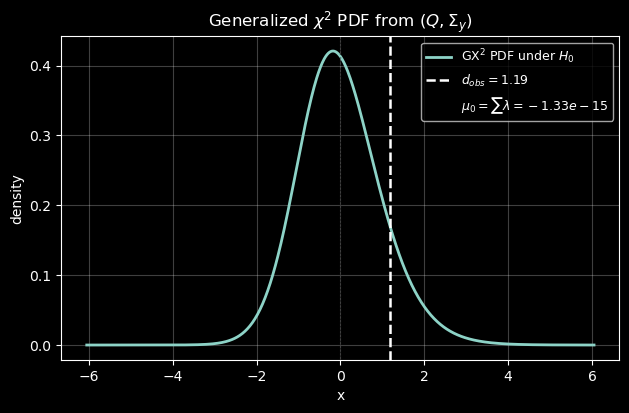

In [12]:
os_val, y, Q, Sigma_y = os_fourier.get_deflection_coordinates(big_array[-1])
fig, ax = plot_pdf(Q, Sigma_y, os_val, complex_mode=False,cutoff=1e-12, npts=800)
plt.show()

### posterior-predictive p

In [13]:
num_p=100
p_arr=[]
for i in range(num_p):
    os_vali, yi, Qi, Sigma_yi = os_fourier.get_deflection_coordinates(big_array[-(i+1)])
    p_righti = spectral_and_pvalue_from_yQ( Qi, Sigma_yi,os_vali)
    p_arr.append(p_righti)
p_arr=np.array(p_arr)
p_ave=np.average(p_arr)
print(p_ave)

0.11624540696648011
